In [100]:
import numpy as np
from scipy.signal import argrelextrema
from scipy.signal import find_peaks,detrend
import csv
import math
import matplotlib.pyplot as plt
import glob
from scipy.signal import kaiserord, lfilter, firwin

In [101]:
def fourier_extrapolation(x, n_harm):
    n = x.size
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)  # find linear trend in x
    x_notrend = x - p[0] * t  # detrended x
    x_freqdom = np.fft.fft(x_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)  # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key=lambda i: np.absolute(f[i]))

    t = np.arange(0, n )
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n  # amplitude
        phase = np.angle(x_freqdom[i])  # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
#     fig = plt.figure(figsize=(15,5))
#     ax = fig.subplots()
#     ax.plot(x,label = 'Original Signal')
#     ax.plot(restored_sig + p[0] * t,label = str(n_harm)+' Furier Signal')
#     ax.legend()
#     ax.grid()
#     plt.show()
    return restored_sig + p[0] * t

In [106]:
def get_mag_mean_filter_kernel5(file_name,mode,k_val=None):
    actual_steps=None
    t_arr=[]
    x_arr=[]
    y_arr=[]
    z_arr=[]
    mag_arr=[]
    mean_mag_arr=[]
# Read data from csv file
    with open(file_name, newline='') as csvfile:
        for i,row in enumerate(csvfile):
            row=row.replace("\n","")
            row=row.replace('"',"")
            row = row.split(',')
            if i==3:
                actual_steps=int(row[1])
            if i>=6:
                row=[float(j) for j in row]
                t_arr.append(row[0])
                x_arr.append(row[1])
                y_arr.append(row[2])
                z_arr.append(row[3])
                
# Compute magnitude and normalize it.                
    x_arr=np.array(x_arr)
    y_arr=np.array(y_arr)
    z_arr=np.array(z_arr)
    mag_arr = np.sqrt(x_arr**2 + y_arr**2 + z_arr**2)          
    mean_mag_arr=mag_arr-np.mean(mag_arr)
   
# # Convolution
#     filter_window_size=3
#     mag_mean_filter_kernel5 = np.convolve(mean_mag_arr, 
#                            np.ones((filter_window_size,))/filter_window_size, 
#                            mode='valid')
    

    signal=None
    if k_val is None:
        for k in range(500,1000):
            signal=fourier_extrapolation(mean_mag_arr, k)
            mse = (np.square(signal - mean_mag_arr)).mean(axis=0)
            if mse< 0.001:
                k_val=k
                break
    else:
        signal=fourier_extrapolation(signal, k_val)
        
    

    
#   Low-pass FIR-filter
    sample_rate = None
    for i in range(len(t_arr)):
        if t_arr[i]-t_arr[0]>1.0:
            sample_rate=i
            break
            
    nsamples = len(signal)
    t = np.arange(nsamples) / sample_rate
    
    # The Nyquist rate of the signal acc to Nyquist Theorem.
    nyq_rate = sample_rate / 2.0
    width = 5.0/nyq_rate
    ripple_db = 60.0
    N, beta = kaiserord(ripple_db, width)
    
    cutoff_hz=3.0
    if mode=="running":
        cutoff_hz = 4.0
    
    taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
    
    signal = lfilter(taps, 1.0, signal)
    
    
#     fig = plt.figure(figsize=(15,5))
#     ax = fig.subplots()
#     ax.plot(mean_mag_arr,label = 'Original Signal')
#     ax.plot(mag_mean_filter_kernel5,label = 'Conv Signal')
#     ax.plot(signal,label = 'FIR Signal')
#     ax.legend()
#     ax.grid()
#     plt.show()
    return signal,actual_steps,sample_rate,k_val

def get_all_maxima(data):
    # Returns all posible maxima of the signal
    peaks=[]
    n=len(data)-1
    i=1
    while i< n:
        if data[i - 1] < data[i]:
            i_ahead = i + 1
            while i_ahead < n and data[i_ahead] == data[i]:
                i_ahead += 1
            if data[i_ahead] < data[i]:
                peaks.append( (i + i_ahead - 1) // 2)
                i = i_ahead
        i += 1

    return np.array(peaks,dtype=np.intp)

def get_peaks_by_threshold(data, maxima_pos, threshold):
    # Returns maxima of the signal filtered by threshold
    data=np.array(data)
    maxima_pos=np.array(maxima_pos)
    count=0
    peaks=[]
    peaks_pos=[]
    for i in range(1,len(data)-1):
        if i in maxima_pos:
            left=data[i-1]
            right=data[i+1]
            peak=data[i]
            min_val=min(peak-right,peak-left)
            if min_val>=threshold:
                peaks.append(peak)
                peaks_pos.append(i)
                count+=1
    return np.array(peaks_pos),np.array(peaks)

def calc_threshold(data,actual_steps):
    min_diff=None
    best_thesh=None
    calc_peaks=None
    for threshold in np.arange(0,0.1,0.001):
        maxima_pos = get_all_maxima(data)
        peaks_pos,peaks = get_peaks_by_threshold(data, maxima_pos, threshold)
        diff=abs(actual_steps-len(peaks))
        if min_diff is None or min_diff>diff:
            min_diff=diff
            best_thesh=threshold
            calc_peaks=len(peaks)
    return best_thesh


def set_threshold_dict(sample_rate,threshold_dict,data,actual_steps):
    if sample_rate<=10:
        threshold_dict[10].append(calc_threshold(data,actual_steps))
    elif sample_rate<=20:
        threshold_dict[20].append(calc_threshold(data,actual_steps))
    elif sample_rate<=30:
        threshold_dict[30].append(calc_threshold(data,actual_steps))
    elif sample_rate<=40:
        threshold_dict[40].append(calc_threshold(data,actual_steps))
    elif sample_rate<=50:
        threshold_dict[50].append(calc_threshold(data,actual_steps))
    elif sample_rate<=60:
        threshold_dict[60].append(calc_threshold(data,actual_steps))
    elif sample_rate<=70:
        threshold_dict[70].append(calc_threshold(data,actual_steps))
    elif sample_rate<=80:
        threshold_dict[80].append(calc_threshold(data,actual_steps))
    elif sample_rate<=90:
        threshold_dict[90].append(calc_threshold(data,actual_steps))
    else:
        threshold_dict[100].append(calc_threshold(data,actual_steps))
        
def get_thershold(threshold_dict,sample_rate):
    if sample_rate<=10:
        return threshold_dict[10]
    elif sample_rate<=20:
        return threshold_dict[20]
    elif sample_rate<=30:
        return threshold_dict[30]
    elif sample_rate<=40:
        return threshold_dict[40]
    elif sample_rate<=50:
        return threshold_dict[50]
    elif sample_rate<=60:
        return threshold_dict[60]
    elif sample_rate<=70:
        return threshold_dict[70]
    elif sample_rate<=80:
        return threshold_dict[80]
    elif sample_rate<=90:
        return threshold_dict[90]
    else:
        return threshold_dict[100]


        
def check_algo(mode, getSignal):
    walking_data = glob.glob("data/"+mode+"/*.csv") 
    threshold_dict={10:[],20:[],30:[],40:[],50:[],60:[],70:[],80:[],90:[],100:[]}
    for file in walking_data:
        data,actual_steps,sample_rate,k_val=getSignal(file,mode,None)
        set_threshold_dict(sample_rate,threshold_dict,data,actual_steps)
    optimal_threshold_dict={}
    for key,val in threshold_dict.items():
        optimal_thresh=np.array(threshold_dict[key]).mean()
        optimal_threshold_dict[key]=optimal_thresh
        
    print(optimal_threshold_dict)
    
    for file in walking_data:
        data,actual_steps,sample_rate,k_val=getSignal(file,mode,k_val)
        print("COUNT OF ACTUAL STEPS: ",actual_steps)
        maxima_pos = get_all_maxima(data)
        threshold=get_thershold(optimal_threshold_dict,sample_rate)
        peaks_pos,peaks = get_peaks_by_threshold(data, maxima_pos, threshold)
        print("COUNT OF CALCULATED STEPS: ",len(peaks))
        diff=abs(actual_steps-len(peaks))
        print("Difference threshold: ",diff)
        print("-"*50)
        #Plotting
#         fig = plt.figure(figsize=(15,5))
#         ax = fig.subplots()
#         ax.plot(data)
#         ax.scatter(peaks_pos,peaks, color = 'r', s = 15, marker = 'D', label = 'Maxima')
#         ax.legend()
#         ax.grid()
#         plt.show()

In [107]:
check_algo("walking",get_mag_mean_filter_kernel5)

{10: 0.08280000000000001, 20: 0.025, 30: 0.004, 40: nan, 50: nan, 60: nan, 70: nan, 80: nan, 90: nan, 100: nan}


<ipython-input-106-33f1731e4fb7>:192: RuntimeWarning: Mean of empty slice.
  optimal_thresh=np.array(threshold_dict[key]).mean()


AttributeError: 'NoneType' object has no attribute 'size'

In [75]:
check_algo("walking",get_mag_mean_filter_kernel5)

{10: 0.033800000000000004, 20: 0.0, 30: 0.00025, 40: nan, 50: nan, 60: nan, 70: nan, 80: nan, 90: nan, 100: nan}
COUNT OF ACTUAL STEPS:  103
COUNT OF CALCULATED STEPS:  101
Difference threshold:  2
--------------------------------------------------
COUNT OF ACTUAL STEPS:  113
COUNT OF CALCULATED STEPS:  109
Difference threshold:  4
--------------------------------------------------
COUNT OF ACTUAL STEPS:  100
COUNT OF CALCULATED STEPS:  99
Difference threshold:  1
--------------------------------------------------
COUNT OF ACTUAL STEPS:  116
COUNT OF CALCULATED STEPS:  117
Difference threshold:  1
--------------------------------------------------
COUNT OF ACTUAL STEPS:  103
COUNT OF CALCULATED STEPS:  109
Difference threshold:  6
--------------------------------------------------
COUNT OF ACTUAL STEPS:  112
COUNT OF CALCULATED STEPS:  113
Difference threshold:  1
--------------------------------------------------
COUNT OF ACTUAL STEPS:  100
COUNT OF CALCULATED STEPS:  101
Difference t

<ipython-input-74-bf6a21593b74>:177: RuntimeWarning: Mean of empty slice.
  optimal_thresh=np.array(threshold_dict[key]).mean()


In [91]:
check_algo("running",get_mag_mean_filter_kernel5)

<ipython-input-89-fecb07744dcd>:185: RuntimeWarning: Mean of empty slice.
  optimal_thresh=np.array(threshold_dict[key]).mean()


{10: 0.05800000000000001, 20: nan, 30: 0.029, 40: nan, 50: nan, 60: nan, 70: nan, 80: nan, 90: nan, 100: nan}
COUNT OF ACTUAL STEPS:  163
COUNT OF CALCULATED STEPS:  163
Difference threshold:  0
--------------------------------------------------
COUNT OF ACTUAL STEPS:  160
COUNT OF CALCULATED STEPS:  167
Difference threshold:  7
--------------------------------------------------
COUNT OF ACTUAL STEPS:  157
COUNT OF CALCULATED STEPS:  161
Difference threshold:  4
--------------------------------------------------
COUNT OF ACTUAL STEPS:  163
COUNT OF CALCULATED STEPS:  162
Difference threshold:  1
--------------------------------------------------
COUNT OF ACTUAL STEPS:  160
COUNT OF CALCULATED STEPS:  161
Difference threshold:  1
--------------------------------------------------
COUNT OF ACTUAL STEPS:  163
COUNT OF CALCULATED STEPS:  156
Difference threshold:  7
--------------------------------------------------
COUNT OF ACTUAL STEPS:  164
COUNT OF CALCULATED STEPS:  165
Difference thr

In [76]:
check_algo("running",get_mag_mean_filter_kernel5)

{10: 0.030400000000000003, 20: nan, 30: 0.00175, 40: nan, 50: nan, 60: nan, 70: nan, 80: nan, 90: nan, 100: nan}
COUNT OF ACTUAL STEPS:  163
COUNT OF CALCULATED STEPS:  161
Difference threshold:  2
--------------------------------------------------
COUNT OF ACTUAL STEPS:  160
COUNT OF CALCULATED STEPS:  162
Difference threshold:  2
--------------------------------------------------
COUNT OF ACTUAL STEPS:  157
COUNT OF CALCULATED STEPS:  159
Difference threshold:  2
--------------------------------------------------
COUNT OF ACTUAL STEPS:  163
COUNT OF CALCULATED STEPS:  162
Difference threshold:  1
--------------------------------------------------
COUNT OF ACTUAL STEPS:  160
COUNT OF CALCULATED STEPS:  159
Difference threshold:  1
--------------------------------------------------
COUNT OF ACTUAL STEPS:  163
COUNT OF CALCULATED STEPS:  150
Difference threshold:  13
--------------------------------------------------
COUNT OF ACTUAL STEPS:  164
COUNT OF CALCULATED STEPS:  162
Difference

<ipython-input-74-bf6a21593b74>:177: RuntimeWarning: Mean of empty slice.
  optimal_thresh=np.array(threshold_dict[key]).mean()


In [85]:
actual_steps=None
t_arr=[]
x_arr=[]
y_arr=[]
z_arr=[]
mag_arr=[]
mean_mag_arr=[]
# Read data from csv file
with open("data/walking/walk_1.csv", newline='') as csvfile:
    for i,row in enumerate(csvfile):
        row=row.replace("\n","")
        row=row.replace('"',"")
        row = row.split(',')
        if i==3:
            actual_steps=int(row[1])
        if i>=6:
            row=[float(j) for j in row]
            t_arr.append(row[0])
            x_arr.append(row[1])
            y_arr.append(row[2])
            z_arr.append(row[3])

# Compute magnitude and normalize it.                
x_arr=np.array(x_arr)
y_arr=np.array(y_arr)
z_arr=np.array(z_arr)
mag_arr = np.sqrt(x_arr**2 + y_arr**2 + z_arr**2)          
mean_mag_arr=mag_arr-np.mean(mag_arr)

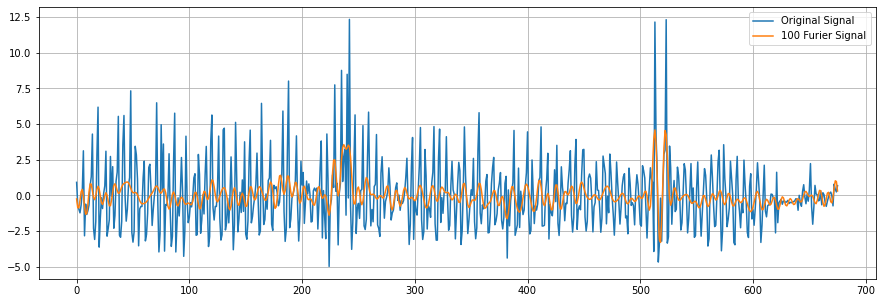

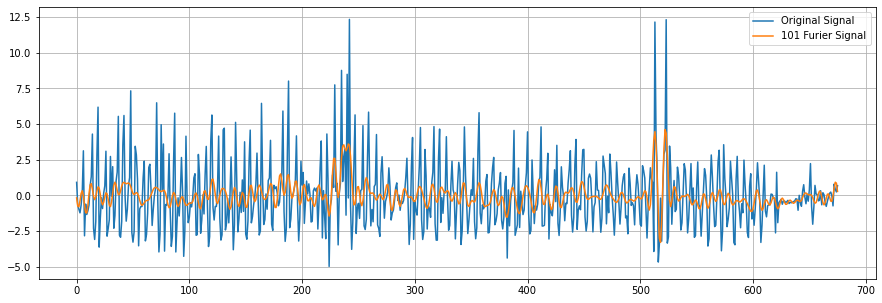

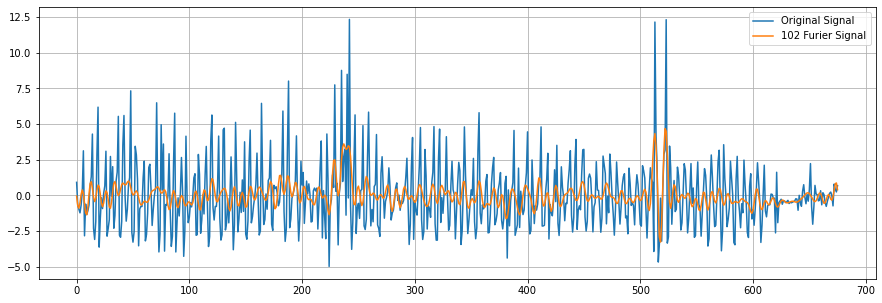

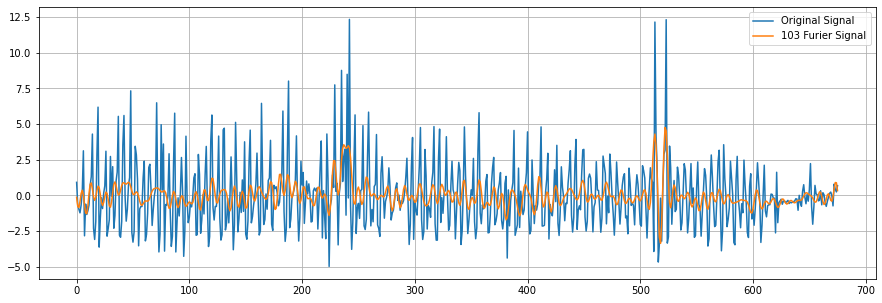

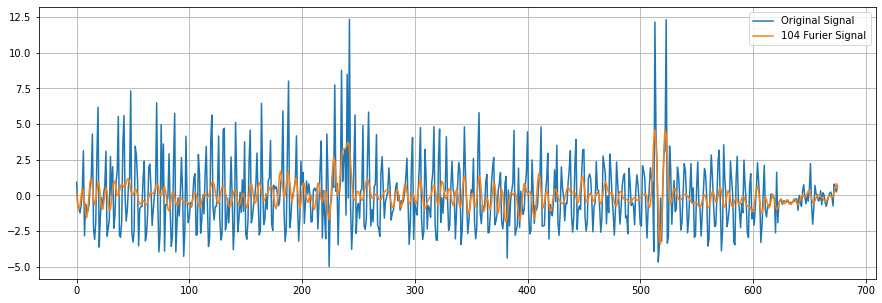

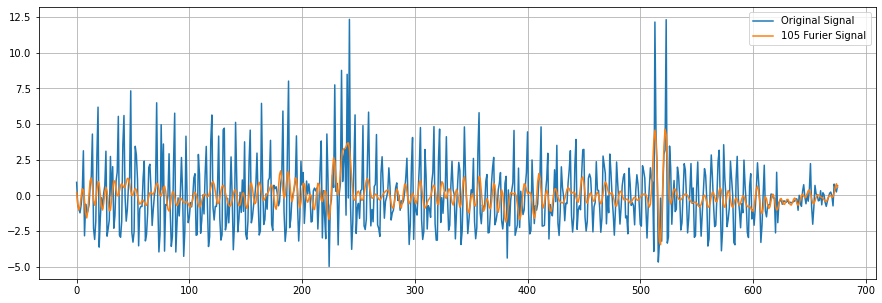

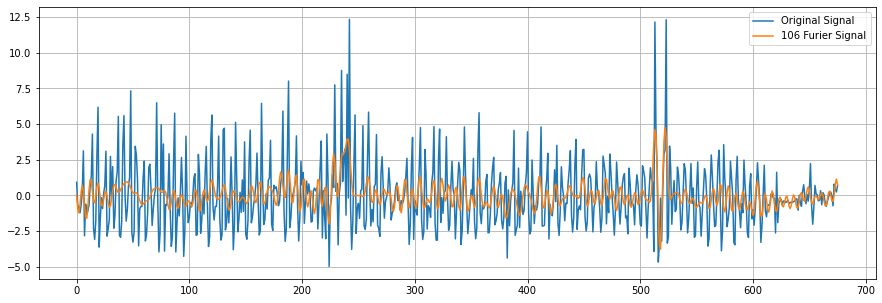

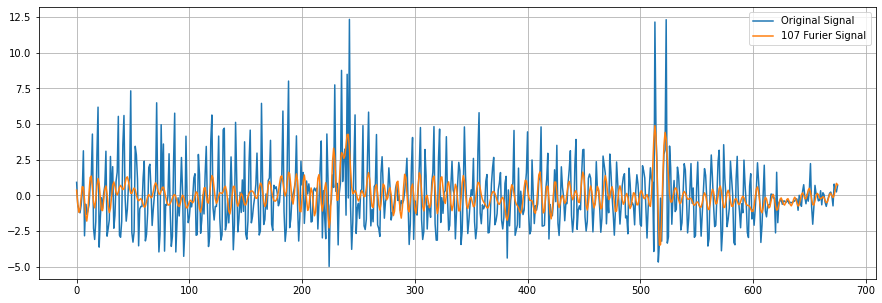

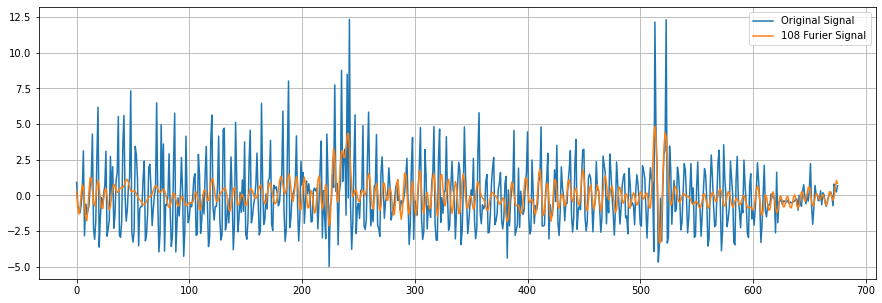

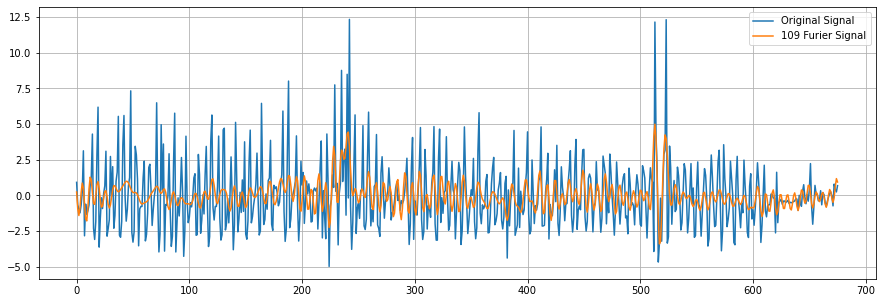

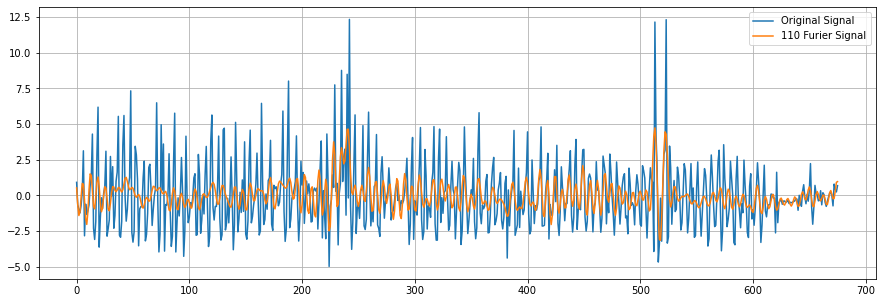

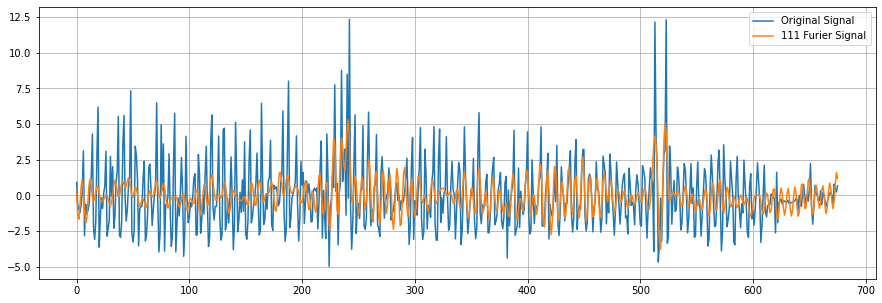

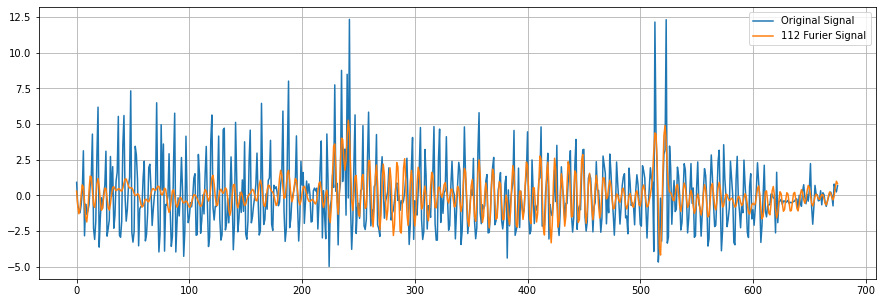

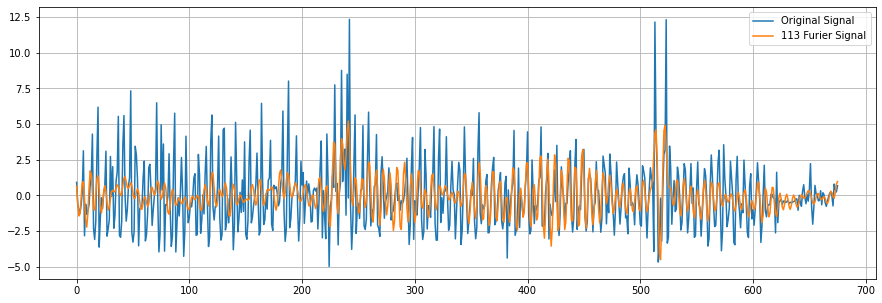

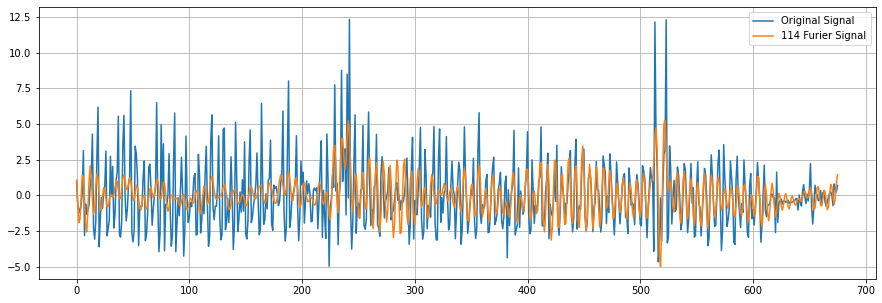

3.946718844440847


In [87]:
for k in range(100,10000):
    signal=fourier_extrapolation(mean_mag_arr, k)
    if prev_signal is None:
        prev_signal=signal
    else:
        mse = (np.square(signal - mean_mag_arr)).mean(axis=0)
        if mse< 4.0:
            print(mse)
            break
            
            

    